In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
plt.style.use('ggplot')

In [2]:
# Read in the dataframes
train_df = pd.read_parquet('../input/train_df.parquet.gzip')
test_df = pd.read_parquet('../input/test_df.parquet.gzip')
features_df = pd.read_parquet('../input/features_df.parquet.gzip')

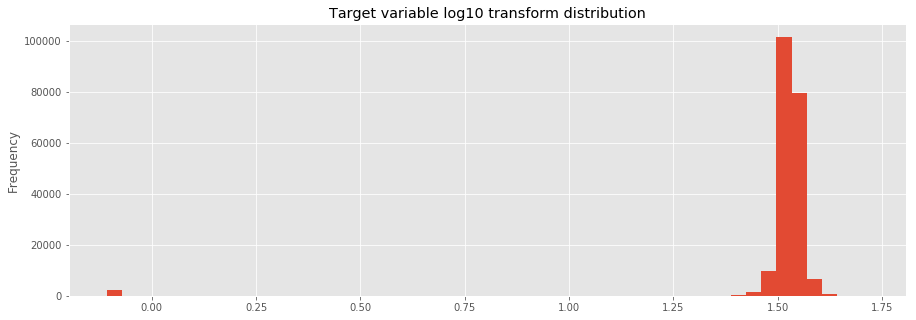

In [3]:
train_df['target_log10p'] = (train_df['target'] + 34).apply(np.log10)
train_df['target_log10p'].plot(kind='hist',
                               bins=50,
                               figsize=(15, 5),
                               title='Target variable log10 transform distribution')
plt.show()

In [4]:
print(min(train_df['target_log10p']), max(train_df['target_log10p']))

-0.10750522346745855 1.7157115032709462


In [5]:
def merge_transactions(df, features_df):
    """Merges the historic and new transactions data with train or test set"""
    df = pd.merge(df, features_df, on='card_id', how='left')
    return df

In [6]:
train_df = merge_transactions(train_df, features_df)
train_df.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_log10p,hist_date_min,hist_date_max,hist_trans_min,...,new_subsector_32_pct,new_subsector_33_pct,new_subsector_34_pct,new_subsector_35_pct,new_subsector_36_pct,new_subsector_37_pct,new_subsector_38_pct,new_subsector_39_pct,new_subsector_40_pct,new_subsector_41_pct
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,1.520873,2017-06-27 14:18:08,2018-02-25 09:31:15,-0.739395,...,0.0,0.000000,0.043478,0.0,0.000000,0.478261,0.0,0.086957,0.0,0.043478
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1.536469,2017-01-06 16:29:42,2018-01-31 22:31:09,-0.742400,...,0.0,0.166667,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,1.540180,2017-01-11 08:21:22,2018-02-27 19:08:25,-0.730138,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.533295,2017-09-26 16:22:21,2018-02-28 11:44:40,-0.740897,...,0.0,0.000000,0.000000,0.0,0.000000,0.428571,0.0,0.000000,0.0,0.000000
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,1.529434,2017-11-12 00:00:00,2018-02-28 20:40:41,-0.746156,...,0.0,0.055556,0.055556,0.0,0.027778,0.472222,0.0,0.000000,0.0,0.000000


In [7]:
test_df = merge_transactions(test_df, features_df)
test_df.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_date_min,hist_date_max,hist_trans_min,hist_trans_max,hist_trans_median,...,new_subsector_32_pct,new_subsector_33_pct,new_subsector_34_pct,new_subsector_35_pct,new_subsector_36_pct,new_subsector_37_pct,new_subsector_38_pct,new_subsector_39_pct,new_subsector_40_pct,new_subsector_41_pct
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017-04-04 18:22:24,2017-12-29 01:05:24,-0.743902,0.235676,-0.691610,...,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017-01-13 15:31:38,2018-02-18 21:30:11,-0.731881,0.318817,-0.679288,...,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017-08-25 14:55:37,2018-02-02 18:57:03,-0.536537,2.525866,0.214624,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017-12-04 12:55:13,2018-02-20 11:42:39,-0.731881,0.087965,-0.587492,...,0.0,0.0,0.100000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,2017-01-03 11:50:27,2018-02-27 10:42:04,-0.746758,15.782255,-0.671775,...,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.0


In [8]:
# Fill the NA value with the last month
test_df['first_active_month'] = test_df['first_active_month'].fillna(pd.Timestamp('2018-01-01'))

In [9]:
def create_features(df, target=False):
    """
    Creates raw features including one hot encoding for train and test
    """
    # One-hot encode features
    feature_1_df = pd.get_dummies(df['feature_1'], prefix='f1_')
    feature_2_df = pd.get_dummies(df['feature_2'], prefix='f2_')
    feature_3_df = pd.get_dummies(df['feature_3'], prefix='f3_')
    # Time delta since first active date
    df['hist_date_min_delta'] = (df['hist_date_min'] - df['first_active_month']).dt.days.astype(float)
    df['hist_date_max_delta'] = (df['hist_date_max'] - df['first_active_month']).dt.days.astype(float)
    df['new_date_min_delta'] = (df['new_date_min'] - df['first_active_month']).dt.days.astype(float)
    df['new_date_max_delta'] = (df['new_date_max'] - df['first_active_month']).dt.days.astype(float)
    # Historical and new transcation features
    col_fltr =\
    ['hist_trans_min',
     'hist_trans_max',
     'hist_trans_median',
     'hist_trans_std',
     'hist_trans_sum',
     'hist_trans_count',
     'hist_auth_min_n',
     'hist_auth_min_y',
     'hist_auth_max_n',
     'hist_auth_max_y',
     'hist_auth_median_n',
     'hist_auth_median_y',
     'hist_auth_std_n',
     'hist_auth_std_y',
     'hist_auth_sum_n',
     'hist_auth_sum_y',
     'hist_auth_count_y_pct',
     'hist_install_count_y_pct',
     'hist_cat_1_y_pct',
     'hist_cat_2_1_pct',
     'hist_cat_2_2_pct',
     'hist_cat_2_3_pct',
     'hist_cat_2_4_pct',
     'hist_cat_2_5_pct',
     'hist_cat_3_A_pct',
     'hist_cat_3_B_pct',
     'hist_cat_3_C_pct',
     'hist_cat_4_n_pct',
     'hist_cat_4_y_pct',
     'hist_subsector_1_pct',
     'hist_subsector_2_pct',
     'hist_subsector_3_pct',
     'hist_subsector_4_pct',
     'hist_subsector_5_pct',
     'hist_subsector_7_pct',
     'hist_subsector_8_pct',
     'hist_subsector_9_pct',
     'hist_subsector_10_pct',
     'hist_subsector_11_pct',
     'hist_subsector_12_pct',
     'hist_subsector_13_pct',
     'hist_subsector_14_pct',
     'hist_subsector_15_pct',
     'hist_subsector_16_pct',
     'hist_subsector_17_pct',
     'hist_subsector_18_pct',
     'hist_subsector_19_pct',
     'hist_subsector_20_pct',
     'hist_subsector_21_pct',
     'hist_subsector_22_pct',
     'hist_subsector_23_pct',
     'hist_subsector_24_pct',
     'hist_subsector_25_pct',
     'hist_subsector_26_pct',
     'hist_subsector_27_pct',
     'hist_subsector_28_pct',
     'hist_subsector_29_pct',
     'hist_subsector_30_pct',
     'hist_subsector_31_pct',
     'hist_subsector_32_pct',
     'hist_subsector_33_pct',
     'hist_subsector_34_pct',
     'hist_subsector_35_pct',
     'hist_subsector_36_pct',
     'hist_subsector_37_pct',
     'hist_subsector_38_pct',
     'hist_subsector_39_pct',
     'hist_subsector_40_pct',
     'hist_subsector_41_pct',
     'new_trans_min',
     'new_trans_max',
     'new_trans_median',
     'new_trans_std',
     'new_trans_sum',
     'new_trans_count',
     'new_install_count_y_pct',
     'new_cat_1_y_pct',
     'new_cat_2_1_pct',
     'new_cat_2_2_pct',
     'new_cat_2_3_pct',
     'new_cat_2_4_pct',
     'new_cat_2_5_pct',
     'new_cat_3_A_pct',
     'new_cat_3_B_pct',
     'new_cat_3_C_pct',
     'new_cat_4_n_pct',
     'new_cat_4_y_pct',
     'new_subsector_1_pct',
     'new_subsector_2_pct',
     'new_subsector_3_pct',
     'new_subsector_4_pct',
     'new_subsector_5_pct',
     'new_subsector_7_pct',
     'new_subsector_8_pct',
     'new_subsector_9_pct',
     'new_subsector_10_pct',
     'new_subsector_11_pct',
     'new_subsector_12_pct',
     'new_subsector_13_pct',
     'new_subsector_14_pct',
     'new_subsector_15_pct',
     'new_subsector_16_pct',
     'new_subsector_17_pct',
     'new_subsector_18_pct',
     'new_subsector_19_pct',
     'new_subsector_20_pct',
     'new_subsector_21_pct',
     'new_subsector_22_pct',
     'new_subsector_23_pct',
     'new_subsector_24_pct',
     'new_subsector_25_pct',
     'new_subsector_26_pct',
     'new_subsector_27_pct',
     'new_subsector_28_pct',
     'new_subsector_29_pct',
     'new_subsector_30_pct',
     'new_subsector_31_pct',
     'new_subsector_32_pct',
     'new_subsector_33_pct',
     'new_subsector_34_pct',
     'new_subsector_35_pct',
     'new_subsector_36_pct',
     'new_subsector_37_pct',
     'new_subsector_38_pct',
     'new_subsector_39_pct',
     'new_subsector_40_pct',
     'new_subsector_41_pct',
     'hist_date_min_delta',
     'hist_date_max_delta',
     'new_date_min_delta',
     'new_date_max_delta']
    trans_features_df = df[col_fltr]
    if target:
        return pd.concat([feature_1_df, feature_2_df, feature_3_df, trans_features_df], axis=1, sort=False), df['target']
    return pd.concat([feature_1_df, feature_2_df, feature_3_df, trans_features_df], axis=1, sort=False)

In [10]:
# preparing training and testing data set
X_train_df, y_train_df = create_features(train_df, target=True)
X_test_df = create_features(test_df, target=False)

In [11]:
# split the train data set into train and validation
X_train_tr_df, X_train_val_df, y_train_tr_df, y_train_val_df = train_test_split(X_train_df,
                                                                                y_train_df,
                                                                                test_size=0.8,
                                                                                random_state=123)

In [12]:
# cross validation to find the best numner of boost rounds 
dtrain = xgb.DMatrix(X_train_tr_df, label=y_train_tr_df.values)
dval = xgb.DMatrix(X_train_val_df, label=y_train_val_df.values)
params = {'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10,
          'silent': 1}
cv_results = xgb.cv(params=params,
                    dtrain=dtrain,
                    num_boost_round=5000,
                    nfold=5,
                    early_stopping_rounds=100,
                    as_pandas=True,
                    verbose_eval=10,
                    seed=123)
cv_results["test-rmse-mean"].tail(1)

[0]	train-rmse:3.91653+0.041528	test-rmse:3.91997+0.165864
[10]	train-rmse:3.74671+0.0397741	test-rmse:3.82262+0.163495
[20]	train-rmse:3.66334+0.038418	test-rmse:3.80081+0.158852
[30]	train-rmse:3.60465+0.0388832	test-rmse:3.79511+0.158409
[40]	train-rmse:3.55604+0.0457732	test-rmse:3.79277+0.154234
[50]	train-rmse:3.5085+0.0475986	test-rmse:3.79359+0.153301
[60]	train-rmse:3.46849+0.0467203	test-rmse:3.7944+0.150944
[70]	train-rmse:3.42922+0.0476825	test-rmse:3.79544+0.149544
[80]	train-rmse:3.38945+0.0459776	test-rmse:3.79784+0.149946
[90]	train-rmse:3.35318+0.0426791	test-rmse:3.79932+0.149535
[100]	train-rmse:3.31764+0.0430596	test-rmse:3.79994+0.148969
[110]	train-rmse:3.287+0.0447494	test-rmse:3.80104+0.148722
[120]	train-rmse:3.2549+0.0476814	test-rmse:3.80187+0.149698
[130]	train-rmse:3.22409+0.0487175	test-rmse:3.80335+0.149151
[140]	train-rmse:3.19136+0.0478479	test-rmse:3.8057+0.148217


42    3.792508
Name: test-rmse-mean, dtype: float64

In [13]:
evallist  = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=cv_results.shape[0],
                  evals=evallist,
                  evals_result=evals_result,
                  verbose_eval=10)

[0]	train-rmse:3.91705	eval-rmse:3.93281
[10]	train-rmse:3.75623	eval-rmse:3.83144
[20]	train-rmse:3.6856	eval-rmse:3.81092
[30]	train-rmse:3.63064	eval-rmse:3.80505
[40]	train-rmse:3.58187	eval-rmse:3.8032
[42]	train-rmse:3.57282	eval-rmse:3.8033


In [14]:
print('Number of boosting rounds {0}, Training RMSE: {1}, Testing RMSE: {2}'.format(len(evals_result['train']['rmse']),
                                                                                    evals_result['train']['rmse'][-1],
                                                                                    evals_result['eval']['rmse'][-1]))

Number of boosting rounds 43, Training RMSE: 3.572817, Testing RMSE: 3.803299


In [15]:
# Predict and format submission
dtest = xgb.DMatrix(X_test_df)
preds = model.predict(dtest, ntree_limit = model.best_ntree_limit)
submission_df = pd.concat([test_df['card_id'], pd.Series(preds)], axis = 1)
submission_df = submission_df.rename(columns={0: 'target'})
print('submission shape', submission_df.shape)

submission shape (123623, 2)


In [16]:
# show submission data
submission_df.head(5)

,card_id,target
0,C_ID_0ab67a22ab,-0.809112
1,C_ID_130fd0cbdd,-0.474160
2,C_ID_b709037bc5,-0.873400
3,C_ID_d27d835a9f,-0.192995
4,C_ID_2b5e3df5c2,-1.402318


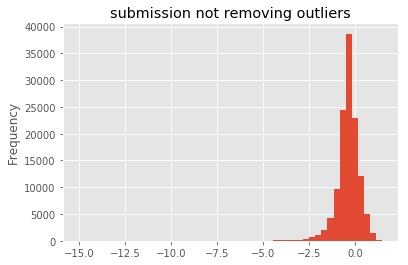

In [17]:
# plot submission distribution
submission_df['target'].plot(kind='hist', bins=50, title='submission not removing outliers')
plt.show()

In [18]:
submission_df.to_csv('../output/xgb_test.csv', index=False)